Keypoint detection and draw

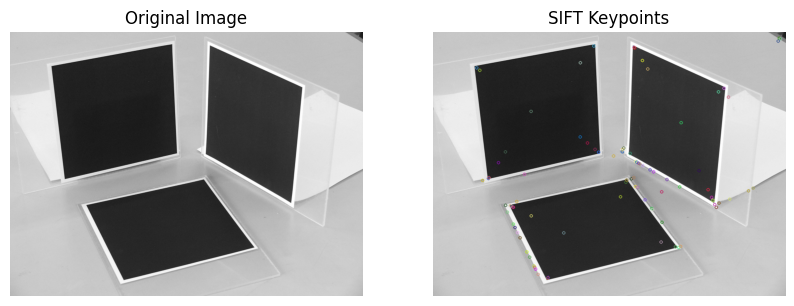

In [3]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# Load the image
img = cv.imread('Images/Image2.jpg')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Apply SIFT
sift = cv.SIFT_create()
kp = sift.detect(gray, None)

# Draw keypoints
img_with_kp = cv.drawKeypoints(gray, kp, img.copy())

# Display images using subplots
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

# Image with SIFT keypoints
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(img_with_kp, cv.COLOR_BGR2RGB))
plt.title("SIFT Keypoints")
plt.axis("off")

# Show the plots
plt.show()

Draws the small circles on the locations of keypoints

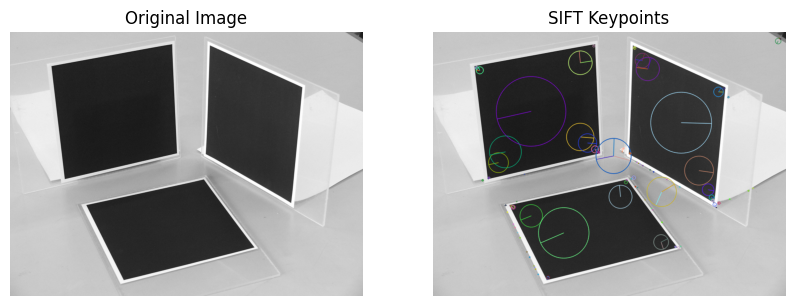

In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# Load the image
img = cv.imread('Images/Image2.jpg')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Apply SIFT
sift = cv.SIFT_create()
kp = sift.detect(gray, None)

# Draw keypoints with rich details
img_with_kp = cv.drawKeypoints(gray, kp, img.copy(), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display images using subplots
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

# Image with SIFT keypoints
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(img_with_kp, cv.COLOR_BGR2RGB))
plt.title("SIFT Keypoints Circles")
plt.axis("off")

# Show the plots
plt.show()